In [1]:
import torch
import logging
logging.basicConfig(level=logging.ERROR)
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3080


In [57]:
#!pip install transformers

# CoLA Dataset
 The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification is used. It’s a set of sentences labeled as grammatically correct or incorrect. <br>
 
 The dataset is hosted on GitHub in this repo: https://nyu-mll.github.io/CoLA/


In [58]:
#!pip install wget

In [59]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

Unzipping the dataset to the file system:

In [60]:
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [61]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
# Display 10 random rows from the data.
df.sample(10)

,sentence_source,label,label_notes,sentence
2389,l-93,1,NaN,Angela characterized Shelly as a lifesaver.
5048,ks08,1,NaN,They're not finding it a stress being in the s...
3133,l-93,0,*,Paul exhaled on Mary.
5955,c_13,0,*,I ordered if John drink his beer.
625,bc01,1,NaN,Press the stamp against the pad completely.
3542,ks08,0,*,They can very.
6915,m_02,1,NaN,This arch is supporting the weight of the tower.
2908,l-93,1,NaN,That new handle detaches easily.
5857,c_13,1,NaN,The Brazilians pumped the oil across the river.
4191,ks08,1,NaN,It is a wooden desk.


In [62]:
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

Number of training sentences: 8,551



<font size="3">The two properties we actually care about are the the sentence and its label, which is referred to as the “acceptibility judgment” (0=unacceptable, 1=acceptable). <br><font size="3">

<font size="3">Here are five sentences which are labeled as not grammatically acceptible:<font size="3">

In [63]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]


,sentence,label
6770,We realised that Dr Jones died because he ate ...,0
1652,Here's a pole for you to kiss the girl who tie...,0
3258,Jennifer baked at the potatoes.,0
4651,Kim is resembled by the model in nearly every ...,0
2672,The book sent to Peter.,0


<font size="3">Extracting the sentences and labels of our training set as numpy ndarrays:<font size="3">

In [64]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

# Tokenization and Input Formatting

<font size="3">Our dataset is transformed into the format that BERT can be trained on.<font size="3">


## BERT Tokenizer

<font size="3">The text should be splitted into tokens to be fed into BERT, and the the tokens must be mapped to their index in the tokenizer vocabulary. The tokenization is performed by the  tokenizer included with BERT<font size="3">

In [65]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


<font size="3">As an example, the tokenizer is applied to one sentence here:<font size="3">

In [66]:
print(' Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


<font size="3"> The <font color='red'> tokenize.encode </font> function is used to implement both steps of tokenizing and mapping to the token ids. Before, tokenization we need to follow the following steps:<br>
1. Add special tokens to the start and end of each sentence.
1. Pad and truncate all sentences to a single constant length.
1. Explicitly differentiate real tokens from padding tokens with   the “attention mask”.
    
    
<font size="4">**[SEP]**<font size="4">

At the end of every sentence, we need to append the special [SEP] token.

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?).



<font size="4">**[CLS]**<font size="4">

For classification tasks, we must append the special [CLS] token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output.
    
    
On the output of the final (12th) transformer, only the first embedding (corresponding to the [CLS] token) is used by the classifier.

“The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks.” 
    
    
* All sentences must be padded or truncated to a single, fixed length.
* The maximum sentence length is 512 tokens.
    
Furthermore, the “Attention Mask” is  an array of 1s and 0s indicating which tokens are padding and which aren’t

In [67]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


Now the following steps are done through **tokenizer.encode_plus**:
1. Split the sentence into tokens.
1. Add the special [CLS] and [SEP] tokens.
1. Map the tokens to their IDs.
1. Pad the sentences to the same length.
1. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.


In [68]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/setareh/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# Training and Validation split

We divide the training set to use 90% for training and 10% for validation:

In [69]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
#To create Torch Dataset just pass your input and labels in the 
#TensorDataset class and it will give you all your data samples
#in torch tensor form. 
dataset = TensorDataset(input_ids, attention_masks, labels)
#DataLoader class arranged your dataset class into small batches. 
# the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))

7695 training samples
856 validation samples


The torch DataLoader class is used that helps saving memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [70]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training
# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Train Our Classification Model

* First, we want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset <br><br>

* The **huggingface** pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Even though each of the interfaces has different top layers and output types designed to accomodate their specific NLP tasks, they are all built on top of a trained BERT model. The following are the classses provided for fine-tuning: <br>
    1. BertModel
    1. **BertForSequenceClassification** - The one we’ll use.
    1. BertForPreTraining
    1. BertForMaskedLM
    1. BertForNextSentencePrediction
    1. BertForTokenClassification
    1. BertForQuestionAnswering
    
The **BertForSequenceClassification** is just a normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

In [71]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    return_dict=False
    )

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [72]:
params = list(model.named_parameters())

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.attention.output.LayerNor

## Optimizer and Learning Rate Scheduler

According to the BERT paper, it is recommended to choose from the following values for the purposes of fine-tuning:<br>
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

The parameters that are chose here:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4

In [73]:
#AdamW is a class from the huggingface library
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/home/setareh/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [74]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [75]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [81]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42
epochs = 8

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#storing the training and validation loss and accuracy:
training_stats = {'epoch': [],'Training Loss': [],'Valid. Loss': [],
            'Valid. Accur.': [],
            'Training Time': [],
            'Validation Time': []}

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    
    # Reset the total loss for this epoch.
    total_train_loss = 0
    
    #Activate the model into training mode. 
    model.train()
    
    for step, batch in enumerate(train_dataloader):
        
        
        
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        
        
        
        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Always clear any previously calculated gradients before backward pass
        model.zero_grad()    
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        #`loss` is a Tensor containing a single value; 
        #the `.item()` function just returns the Python value 
        # from the tensor.

        total_train_loss += loss.item()
        
        # backward pass to calculate the gradients.
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        #Update parameters
        optimizer.step()
        
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)  
    
    
    training_time = format_time(time.time() - t0)
    
    
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))      
    # ========================================
    #               Validation
    # ========================================
    t0 = time.time()      
    # evaluation mode
    model.eval()
          
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
          
    for batch in validation_dataloader:
          
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          #Not compute the graph during the forward pass, since this is
          #only needed for backprop (training).
          with torch.no_grad(): 
              (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
          
    # Accumulate the validation loss.
    total_eval_loss += loss.item()

          
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Validation took: {:}".format(validation_time))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

     # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['Training Loss'].append(avg_train_loss)
    training_stats['Valid. Loss'].append(avg_val_loss)
    training_stats['Valid. Accur.'].append(avg_val_accuracy)
    training_stats['Training Time'].append(training_time)
    training_stats['Validation Time'].append(validation_time)



======== Epoch 1 / 8 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:03.
  Batch    80  of    481.    Elapsed: 0:00:05.
  Batch   120  of    481.    Elapsed: 0:00:08.
  Batch   160  of    481.    Elapsed: 0:00:10.
  Batch   200  of    481.    Elapsed: 0:00:13.
  Batch   240  of    481.    Elapsed: 0:00:15.
  Batch   280  of    481.    Elapsed: 0:00:18.
  Batch   320  of    481.    Elapsed: 0:00:20.
  Batch   360  of    481.    Elapsed: 0:00:23.
  Batch   400  of    481.    Elapsed: 0:00:25.
  Batch   440  of    481.    Elapsed: 0:00:28.
  Batch   480  of    481.    Elapsed: 0:00:30.

  Average training loss: 0.10
  Training epcoh took: 0:00:31
  Accuracy: 0.01
  Validation took: 0:00:01
  Validation Loss: 0.02

======== Epoch 2 / 8 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:03.
  Batch    80  of    481.    Elapsed: 0:00:05.
  Batch   120  of    481.    Elapsed: 0:00:08.
  Batch   160  of    481.    Elapsed: 0:00:10.
  Batch   200  of    481.    Ela

In [82]:
training_stats

{'epoch': [1, 2, 3, 4, 5, 6, 7, 8],
 'Training Loss': [0.1039415763939388,
  0.07985301887653545,
  0.07725108335173535,
  0.06719671030440019,
  0.08448524082458544,
  0.08183192444581387,
  0.06904210334945288,
  0.09238073843015307],
 'Valid. Loss': [0.02015800608528985,
  0.013650674510885167,
  0.011288935387576068,
  0.02510399509359289,
  0.01180672424810904,
  0.010833442211151123,
  0.024644213694113272,
  0.011673182249069214],
 'Valid. Accur.': [0.013888888888888888,
  0.016203703703703703,
  0.016203703703703703,
  0.013888888888888888,
  0.016203703703703703,
  0.016203703703703703,
  0.013888888888888888,
  0.016203703703703703],
 'Training Time': ['0:00:31',
  '0:00:31',
  '0:00:31',
  '0:00:31',
  '0:00:31',
  '0:00:31',
  '0:00:31',
  '0:00:31'],
 'Validation Time': ['0:00:01',
  '0:00:01',
  '0:00:01',
  '0:00:01',
  '0:00:01',
  '0:00:01',
  '0:00:01',
  '0:00:01']}

In [83]:
training_stats["epoch"]

[1, 2, 3, 4, 5, 6, 7, 8]

In [84]:
import pandas as pd


# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.103942,0.020158,0.013889,0:00:31,0:00:01
2,0.079853,0.013651,0.016204,0:00:31,0:00:01
3,0.077251,0.011289,0.016204,0:00:31,0:00:01
4,0.067197,0.025104,0.013889,0:00:31,0:00:01
5,0.084485,0.011807,0.016204,0:00:31,0:00:01
6,0.081832,0.010833,0.016204,0:00:31,0:00:01
7,0.069042,0.024644,0.013889,0:00:31,0:00:01
8,0.092381,0.011673,0.016204,0:00:31,0:00:01


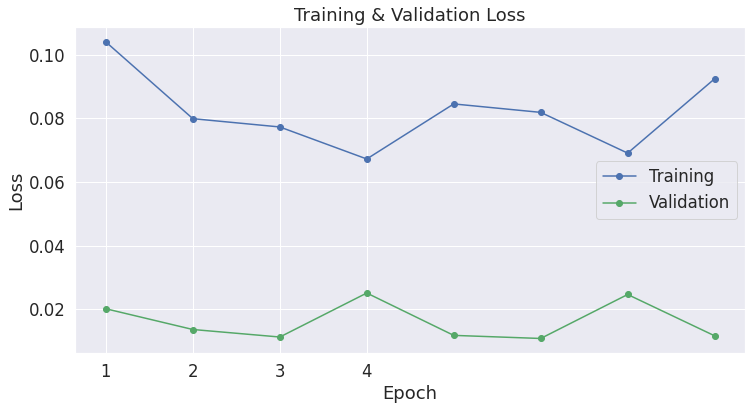

In [85]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Performance On Test Set


Now we load the holdout dataset and then evaluate the predictions using " Matthew’s correlation coefficient". Matthew's correlation coefficient (MCC) is a measure of the quality of binary classification predictions. It takes into account true positives, true negatives, false positives, and false negatives to evaluate the performance of a binary classification model. MCC ranges from -1 to 1, where 1 indicates a perfect prediction, 0 indicates a random prediction, and -1 indicates a total disagreement between the prediction and the ground truth.

MCC = (TP * TN - FP * FN) / sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))


# Data Preparation

In [86]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/home/setareh/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Evaluate on Test Set

We apply our fine-tuned model to generate predictions on the test set.

In [126]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                  attention_mask=b_input_mask)
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')     

Predicting labels for 516 test sentences...
    DONE.


In [128]:
#We use MCC here because the classes are imbalanced:

In [129]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [140]:
from sklearn.metrics import matthews_corrcoef

# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.438


MCC ranges from -1 to 1, where 1 indicates a perfect prediction, 0 indicates a random prediction, and -1 indicates a total disagreement between the prediction and the ground truth.